# Miniproject: Image Classification

### Description

One of the oldest traditions in deep learning is to first tackle the fun problem of MNIST classification. [The MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://keras.io/examples/) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "Adam", "convolutional neural network", "training and validation data", "overfitting", "regularization", and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data (i.e. training).
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [ ]:
student1 = "Aiday Marlen Kyzy"
student2 = "Sander de Haan"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [ ]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import regularizers

# added later
from keras.utils import np_utils
from keras.layers.core import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random 

### Plotting

In [ ]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], ncols = 6, nrows = 4, xdim = 28, ydim = 28, label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "train")
    ax1.plot(history.history['val_loss'], label = "val")
    ax2.plot(history.history['accuracy'], label = "train")
    ax2.plot(history.history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' train')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_adam.history['loss'], label=label2 + ' train')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_sgd.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_sgd.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_adam.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_adam.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (6 points)

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. 
The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the training converges faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to 
wait too long. 

1. As a warm-up exercise, use the importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the function `plot_some_samples` defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (2 pts)
3. To prepare for training: 1. transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (you can use `utils.to_categorical` function from keras), and 2. reshape (flatten) the input images to input vectors and rescale the input data into the range [0,1]. (2 pts)

*Hint*: Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets. 

**Answer to Question 2** (1 sentence): The green digits indicates the predicted class of the image.

### Solution

4423680/4422102 [==============================] - 0s 0us/step


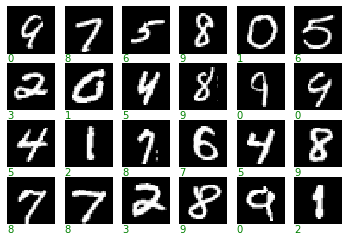

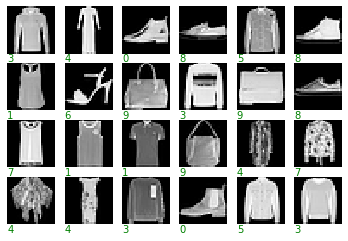

In [ ]:
# Download the data
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = tf.keras.datasets.fashion_mnist.load_data()

# Plot some samples
plot_some_samples(x_mnist_train, y_mnist_train)
plot_some_samples(x_fashion_train, y_fashion_train)

size_of_image = 28*28
num_pixels = 784
num_classes = 10

# Apply one hot-encoding to the classes and prepare the data
y_fashion_train = tf.keras.utils.to_categorical(y_fashion_train, num_classes)
y_fashion_test = tf.keras.utils.to_categorical(y_fashion_test, num_classes)

y_mnist_train = tf.keras.utils.to_categorical(y_mnist_train, num_classes)
y_mnist_test = tf.keras.utils.to_categorical(y_mnist_test, num_classes)

x_fashion_train = x_fashion_train/255 
x_fashion_test = x_fashion_test/255

x_mnist_train = x_mnist_train/255
x_mnist_test = x_mnist_test/255

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], size_of_image).astype('float32')
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], size_of_image).astype('float32')

x_mnist_train = x_mnist_train.reshape(x_mnist_train.shape[0], num_pixels).astype('float32')
x_mnist_test = x_mnist_test.reshape(x_mnist_test.shape[0], num_pixels).astype('float32')

## Exercise 2: No hidden layer (10 points)

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). Note that in this miniproject there is no real test dataset and what is loaded as a test dataset is used for validation. First, implement 1.-3. for the MNIST dataset.  

1. Implement the model with the following specifications: use the softmax activation for the output layer, use the categorical_crossentropy loss, choose stochastic gradient descent for the optimizer, and add the accuracy metric to the metrics. (5 pts)
2. Train for as many epochs as needed to see no further decrease in the validation loss. (1 pt)
3. Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above. (1 pt)
4. Repeat the above steps for fitting the network to the Fashion-MNIST dataset. (2 pts)
5. Report the best validation accuracy achieved for each one of the datasets. Do you observe overfitting already for this simple model? Answer separetely for the MNIST dataset and Fashion-MNIST dataset. (1 pt) 

*Hint:* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).


---
**Answer to Question 5** (max 2 sentences): For the MNIST dataset the best validation accuracy is about 0.97. For the Fashion-MNIST dataset the best validation accuracy is about 0.87. In both cases we observe slight overfitting because the training accuracy is larger than the validation accuracy.


### Solution


In [ ]:
def build_network(number_of_hidden_layers = 0, units = 512, optimizer='sgd', lr = 0.01, dropOut = None, regularization = 0):
    model = Sequential()
    model.add(Dense(units, input_shape=(784,), kernel_regularizer=regularizers.l2(regularization)))
    model.add(Activation('relu'))
    
    if(dropOut != None):
        model.add(Dropout(dropOut))

    if(number_of_hidden_layers > 0) :
        # Build hidden layers
        for i in range(number_of_hidden_layers):
            model.add(Dense(units, kernel_regularizer=regularizers.l2(regularization)))
            model.add(Activation('relu'))
            
            if(dropOut != None):
                model.add(Dropout(dropOut))

    model.add(Dense(10, kernel_regularizer=regularizers.l2(regularization)))
    model.add(Activation('softmax'))
    
    if(dropOut != None):
        model.add(Dropout(dropOut))

    opt = keras.optimizers.SGD(learning_rate = lr)

    if(optimizer == 'adam'):
        opt = keras.optimizers.Adam(learning_rate = lr)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

    return model

In [ ]:
# Building the network
model = build_network()
fashion_model = build_network()

# *** MNIST dataset ***
history = model.fit(x_mnist_train, y_mnist_train, batch_size=128, epochs=100, verbose=1, validation_data=(x_mnist_test, y_mnist_test))

# *** fashion MNIST dataset ***
fashion_history = model.fit(x_fashion_train, y_fashion_train, batch_size=128, epochs=100, verbose=1, validation_data=(x_fashion_test, y_fashion_test))

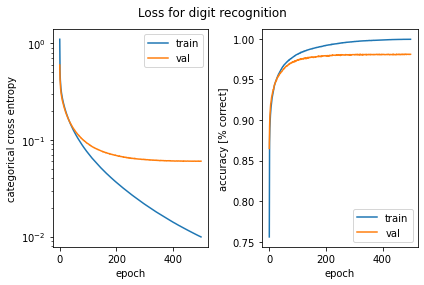

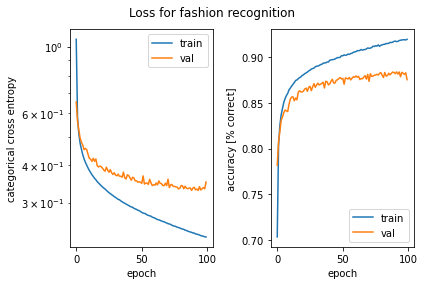

In [ ]:
# Plot the learning curves resulting from the fitting procedure
fig = plot_history(history, "Digit recognition")
fig = plot_history(fashion_history, "Fashion recognition")

print("Best validation accuracy for MNIST data set : " + str(max(history.history['val_accuracy'])))
print("Best validation accuracy for fashion MNIST data set : " + str(max(fashion_history.history['val_accuracy'])))

## Exercise 3: One hidden layer, different optimizers (10 points)

Train a network with one hidden layer and compare different optimizers for the MNIST dataset.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way. (1 pt)
2. Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate $\eta$ is very large (for ex. $\eta=1$), and very small (for ex. $\eta=0.001$)? Comment on the fluctuations of the learning curve. (2 pts)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate). (1pt)
4. Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (1 pts)
5. Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so? (2 pts)
6. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples`. (1 pt)

Real-world datasets are labeled by some people and sometimes there are mistakes in the labeling. We will corrupt labels of the MNIST dataset artifically, and observe an overfitting to this noisy dataset with Adam. 

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)

---

**Answer to Question 2** (max 2 sentences): In the case of a high learning rate of 1, the categorical cross entropy validation an training loss fluctuate a lot, more so than in the case of a learning rate of 0.001, but the overall accuracy is higher for a larger learning rate after 50 epochs. The reason for this is that during stochastic gradient descent, a large learning rate may lead to a quicker convergence to the optimal weights, but will cause larger fluctuations in the weights from epoch to epoch.

**Answer to Question 5** (max 3 sentences): By looking at the categorical cross entropy loss for the Adam optimizer, we notice that while the training loss decreases at each epoch, the validation loss increases, this is indicative of overfitting. In the case of SGD, the training and validation losses are roughly the same over the epochs. Nevertheless the Adam optimizer has a higher best validation accuracy of around 0.96 than the best validation accuracy for SGD which is around 0.95. We can conclude that Adam is a better optimizer. 

**Answer to Question 7** (max 2 sentences): The training accuracy is low at 0.65 %, while the validation accuracy remains relatively high at 0.95%, meaning that the model still predicts accurately. Similarly, for the categorical cross entropy loss, we notice that the training loss is much larger than the validation loss. In fact in this case there isn't a lot of overfitting. After 50 epochs, we get roughly the same accuracy as in the case of noise-free MNIST, so adding noise has some effect but it is not significant.

### Solution

In [ ]:
# *** EXERCISE 3.1 ***
model_exercise_3_1 = build_network(number_of_hidden_layers = 1, units = 128, lr = 0.01)
model_exercise_3_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_9 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
activation_10 (Activation)   (None, 10)                0         
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
________________________________________________

In [ ]:
# *** EXERCISE 3.2 ***
model_exercise_3_2_large = build_network(number_of_hidden_layers = 1, units = 128, optimizer='sgd', lr = 1)
model_exercise_3_2_small = build_network(number_of_hidden_layers = 1, units = 128, optimizer='sgd', lr = 0.001)

# training on 50 epochs, with a learning rate of 1 and 0.001
history_large = model_exercise_3_2_large.fit(x_mnist_train, y_mnist_train,  batch_size=128, epochs=50, verbose=0, validation_data=(x_mnist_test, y_mnist_test))
history_small = model_exercise_3_2_small.fit(x_mnist_train, y_mnist_train,  batch_size=128, epochs=50, verbose=0, validation_data=(x_mnist_test, y_mnist_test))

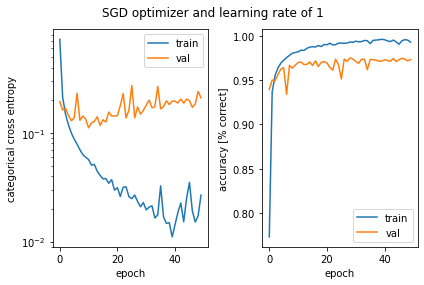

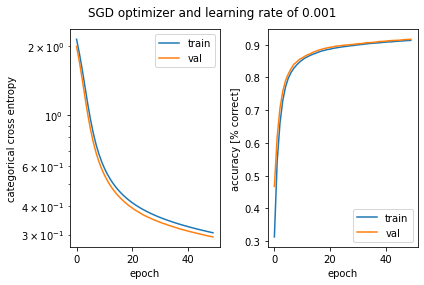

In [ ]:
fig_large = plot_history(history_large, "SGD optimizer and learning rate of 1")
fig_small = plot_history(history_small, "SGD optimizer and learning rate of 0.001")

In [ ]:
# *** EXERCISE 3.3 ***
model_exercise_3_3_SGD = build_network(number_of_hidden_layers = 1, units = 128, optimizer='sgd', lr = 0.01)
history_exercise_3_3_SGD = model_exercise_3_3_SGD.fit(x_mnist_train, y_mnist_train,  batch_size=128, epochs=50, verbose=0, validation_data=(x_mnist_test, y_mnist_test))

model_exercise_3_3_ADAM = build_network(number_of_hidden_layers = 1, units = 128, optimizer='adam', lr = 0.01)
history_exercise_3_3_ADAM = model_exercise_3_3_ADAM.fit(x_mnist_train, y_mnist_train,  batch_size=128, epochs=50, verbose=0, validation_data=(x_mnist_test, y_mnist_test))

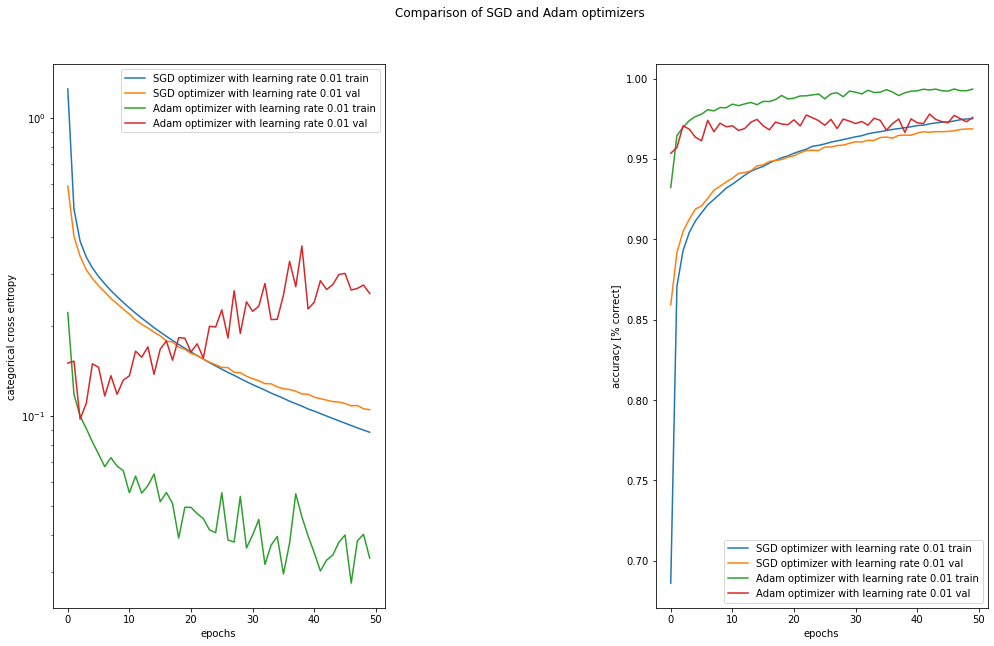

In [ ]:
# *** EXERCISE 3.4 ***

fig_comparison = comparison_plot(history_exercise_3_3_SGD, history_exercise_3_3_ADAM, 'SGD optimizer with learning rate 0.01', 'Adam optimizer with learning rate 0.01', 'Comparison of SGD and Adam optimizers')
fig_comparison.set_size_inches(30,10)

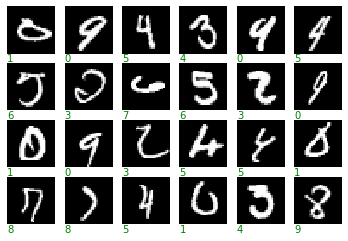

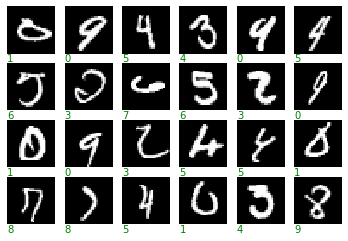

In [ ]:
# *** EXERCISE 3.6 ***

# Missclassified data when using the ADAM optimizer 
x_test_predicted_classes = np.argmax(model_exercise_3_3_ADAM.predict(x_mnist_test), axis=-1)

# Transform back from 1-hot encoding to a class in 0 to 9
y_test_classes = np.empty([10000,])
for index, val in enumerate(y_mnist_test):
    y_test_classes[index] = int(np.where(val==1)[0].item(0))

incorrect_indices = np.where(np.not_equal(x_test_predicted_classes, y_test_classes))

plot_some_samples(x_mnist_test[incorrect_indices], y_mnist_test[incorrect_indices])

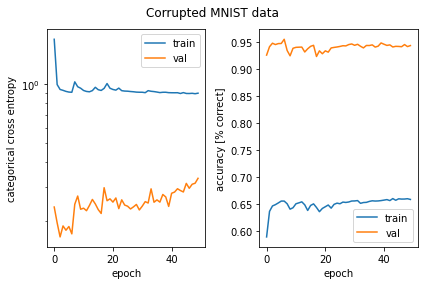

In [ ]:
# *** EXERCISE 3.7 ***
corrupted_x_mnist_train = x_mnist_train

for index, el in enumerate(x_mnist_train):
    if random.random() >= 0.2:
        corrupted_x_mnist_train[index] = x_mnist_train[index]
    else:
        corrupted_x_mnist_train[index] = np.floor(np.random.uniform(1,9))

# Training with Adam on 50 epochs
model_exercise_3_7 = build_network(number_of_hidden_layers = 1, units = 128, optimizer='adam', lr = 0.01)
history_corrupted = model_exercise_3_7.fit(corrupted_x_mnist_train, y_mnist_train,  batch_size=128, epochs=50, verbose=0, validation_data=(x_mnist_test, y_mnist_test))
fig_corrupted = plot_history(history_corrupted, "Corrupted MNIST data")

## Exercise 4: Model performance as a function of number of hidden neurons (8 + 2 points)

Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network in Exercise 3, we use the Fashion-MNIST dataset from now on to compare the performances of more complex models. In this exercise, we investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)
2. Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)
3. Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
4. BONUS: Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
5. Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

**Answer to Question 2** (max 2 sentences): From the plots we see that the minimum loss is for 100 neurons per hidden layer. On either side for 10 and 500 neurons, the loss is higher. Similarly, the accuracy is higher for 100 neurons. We find therefore that for a large number of neurons, there is overfitting. There is a clear increasing trend in the validation loss when working with more parameters. The best validation accuracy in this case is about 0.877 for 100 units.

**Answer to Question 5** (max 3 sentences): In the case of the corrupted fashion-MNIST data set from question 3, the highest accuracy is attained for 250 hidden neurons followed by 100 hidden neurons. Since the data is corrupted, in order to fit the underlying correct data more accurately you need a more flexible network. We cannot draw a comparison to the overfitting of the MNIST database of question 2, as the maximum number of neurons per layers we trained is 250 and for the MNIST database this is 1000 number of neurons per layer, therefore overfitting might still occur with a larger width of the network. In this case the maximum validation accuracy is about 0.8, lower than in the previous case.

**Answer to Question 5 for Bonus** : We also did the bonus question, for which we considered the original dataset to which we added noise with a mean of 0 and a variance of 0.01. The maximum validation accuracy in this case 0.876 is lower than on the original training set but higher than on the corrupted dataset. It would seem that corrupting the dataset impacts the dataset more than adding noise.

### Solution

In [ ]:
# *** EXERCISE 4.2 ***
widths = [10,100,500,1000]
max_acc = {}
min_loss = {}

for width in widths:
    model = build_network(number_of_hidden_layers = 1, units = width, optimizer='adam', lr = 0.01)
    history = model.fit(x_fashion_train, y_fashion_train,  batch_size=128, epochs=50, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
    max_acc[width] = max(history.history['val_accuracy'])
    min_loss[width] = min(history.history['val_loss'])

Text(0, 0.5, 'Minimum loss')

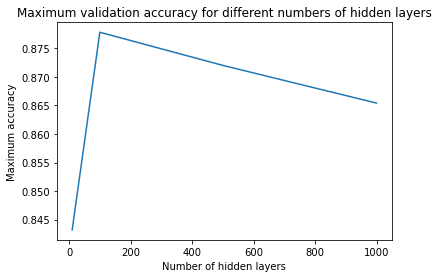

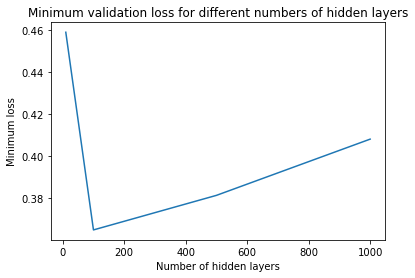

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(widths, max_acc.values())
ax1.set_title("Maximum validation accuracy for different widths")
ax1.set_xlabel("Width of the network")
ax1.set_ylabel("Maximum accuracy")

fig2, ax2 = plt.subplots()
ax2.plot(widths, min_loss.values())
ax2.set_title("Maximum validation accuracy for different widths")
ax2.set_xlabel("Width of the network")
ax2.set_ylabel("Minimum loss")

print("Best validation accuracy : " + str(max(max_acc.values())))

In [ ]:
# **** EXERCISE 4.3 ****
corrupted_x_fashion_train = x_fashion_train

# Change the class labels randomly
for index, el in enumerate(x_fashion_train):
    if random.random() >= 0.5:
        corrupted_x_fashion_train[index] = x_fashion_train[index]
    else:
        corrupted_x_fashion_train[index] = np.floor(np.random.uniform(1,9))

# Fit at least 4 models with different widths between 10 and 250.
widths = [10,100,150,250]
max_acc = {}
min_loss = {}

for width in widths:
    model = build_network(number_of_hidden_layers = 1, units = width, optimizer='adam', lr = 0.01)
    history = model.fit(corrupted_x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
    max_acc[width] = max(history.history['val_accuracy'])
    min_loss[width] = min(history.history['val_loss'])

Text(0, 0.5, 'Minimum loss')

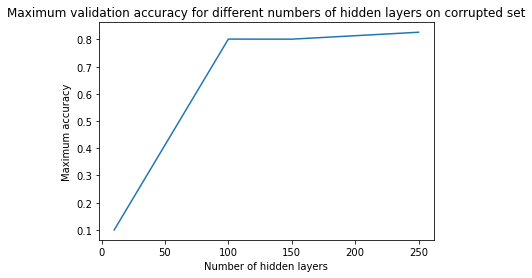

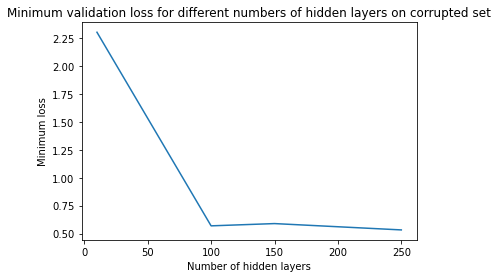

In [ ]:
fig3, ax3 = plt.subplots()
ax3.plot(widths, max_acc.values())
ax3.set_title("Maximum validation accuracy for different widths on a corrupted set")
ax3.set_xlabel("Width of the network")
ax3.set_ylabel("Maximum accuracy")

fig4, ax4 = plt.subplots()
ax4.plot(widths, min_loss.values())
ax4.set_title("Maximum validation accuracy for different widths on a corrupted set")
ax4.set_xlabel("Width of the network")
ax4.set_ylabel("Minimum loss")

print("Best validation accuracy : " + str(max(max_acc.values())))

In [ ]:
# **** EXERCISE 4.4 ****
noisy_x_fashion_train = x_fashion_train + np.random.normal(0,0.01,(x_fashion_train.shape))

In [ ]:
# Fit at least 4 models with different widths between 10 and 250.
widths = [10,100,150,250]
max_acc = {}
min_loss = {}

for width in widths:
    model = build_network(number_of_hidden_layers = 1, units = width, optimizer='adam', lr = 0.01)
    history = model.fit(noisy_x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
    max_acc[width] = max(history.history['val_accuracy'])
    min_loss[width] = min(history.history['val_loss'])

Text(0, 0.5, 'Minimum loss')

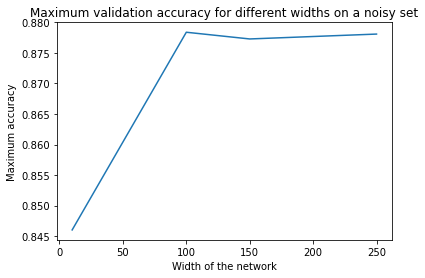

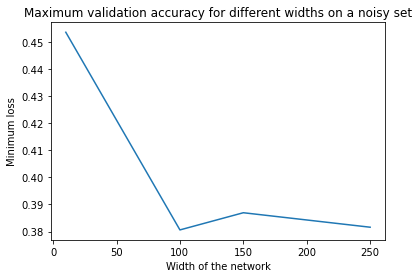

In [ ]:
fig3, ax3 = plt.subplots()
ax3.plot(widths, max_acc.values())
ax3.set_title("Maximum validation accuracy for different widths on a noisy set")
ax3.set_xlabel("Width of the network")
ax3.set_ylabel("Maximum accuracy")

fig4, ax4 = plt.subplots()
ax4.plot(widths, min_loss.values())
ax4.set_title("Maximum validation accuracy for different widths on a noisy set")
ax4.set_xlabel("Width of the network")
ax4.set_ylabel("Minimum loss")

print("Best validation accuracy : " + str(max(max_acc.values())))

## Exercise 5: Going deeper: tricks and regularization (10 + 2 points)

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. We use Fashion-MNIST dataset in this exercise.  

1. Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs. (2 pts)
2. Plot the learning curves and report the best validation accuracy. Do you observe overfitting? (2 pts)
3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?  (2 pts)
4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)
5. BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

6. Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure. (2 pts)

**Answer to Question 2** (max 1 sentence): The best validation accuracy is about 0.8797. We observe overfitting, because as the number of epochs increases the accuracy increases and decreases. At this point we have trained the network too much.

**Answer to Question 3** (max 2 sentences): With a regularization of 1 the validation accuracy is 0.1, and with a regularization of 0.001, the validation accuracy is 0.8449. We notice that a regularization term which is too large, will cause low validation accuracy, it will penalize high weights too much.

**Answer to Question 4** (max 2 sentences): With a drop out of 0.5 we get a validation accuracy of 0.1, and with a drop out of 0.05 we get a validation accuracy of 0.8604. Setting a drop out rate which is too large will cause too many connections to be absent, and the model will not be trained accurately. 

**Answer to Question 6** (max 2 sentences): Both methods to reduce overfitting, regularization and dropout, lead to a higher validation accuracy than originally was the case. While the worst accuracies for both methods are equal, the drop-out regularization method has a higher optimal accuracy than the regularization method.

### Solution

In [ ]:
# *** EXERCISE 5.1 ***
# Choosing units = 100, number of hidden layers = 2
model = build_network(number_of_hidden_layers = 2, units = 100, optimizer='adam', lr = 0.01)
history = model.fit(x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))

Best validation accuracy for 2 hidden layers and 100 units : 0.8797000050544739


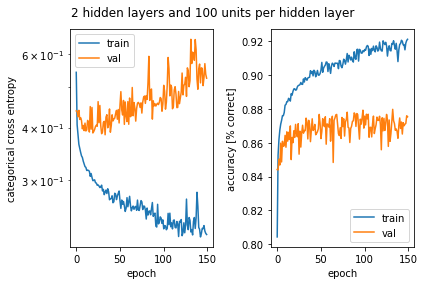

In [ ]:
# *** EXERCISE 5.2 ***
plot_history(history, "2 hidden layers and 100 units per hidden layer")
print("Best validation accuracy for 2 hidden layers and 100 units : " + str(max(history.history['val_accuracy'])))

In [ ]:
# *** EXERCISE 5.3 ***
model_large = build_network(number_of_hidden_layers = 2, units = 100, optimizer='adam', lr = 0.01, regularization = 1)
model_small = build_network(number_of_hidden_layers = 2, units = 100, optimizer='adam', lr = 0.01, regularization = 0.001)

history_large = model_large.fit(x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
history_small = model_small.fit(x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))

In [ ]:
print("Best validation accuracy for 2 hidden layers and 100 units and a regularization of 1 :" + str(max(history_large.history['val_accuracy'])))
print("Best validation accuracy for 2 hidden layers and 100 units and a regularization of 0.001 :" + str(max(history_small.history['val_accuracy'])))

Best validation accuracy for 2 hidden layers and 100 units and a regularization of 1 :0.10000000149011612
Best validation accuracy for 2 hidden layers and 100 units and a regularization of 0.001 :0.8449000120162964


In [ ]:
# *** EXERCISE 5.4 ***
model_large = build_network(number_of_hidden_layers = 2, units = 100, optimizer='adam', lr = 0.01, dropOut = 0.5)
model_small = build_network(number_of_hidden_layers = 2, units = 100, optimizer='adam', lr = 0.01, dropOut = 0.05)

history_large = model_large.fit(x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))
history_small = model_small.fit(x_fashion_train, y_fashion_train,  batch_size=128, epochs=150, verbose=0, validation_data=(x_fashion_test, y_fashion_test))

In [ ]:
print("Best validation accuracy for 2 hidden layers and 100 units and a drop out of 0.5 :" + str(max(history_large.history['val_accuracy'])))
print("Best validation accuracy for 2 hidden layers and 100 units and a drop out of 0.05:" + str(max(history_small.history['val_accuracy'])))

Best validation accuracy for 2 hidden layers and 100 units and a drop out of 0.5 :0.10000000149011612
Best validation accuracy for 2 hidden layers and 100 units and a drop out of 0.05:0.8604000210762024


## Exercise 6: Convolutional neural networks (CNNs) (10 points)

Convolutional neural networks have an inductive bias that is well adapted to image classification. 

1. Design a convolutional neural network and train it without using explicit regularizers. (2 pts)
2. Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases. (4 pts)
3. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot. (2pts)
4. How does the CNN performance compare to the so far best performing (deep) neural network model? (2 pts)

*Hint:* You may get valuable inspiration from the keras [examples](https://keras.io/examples/), [for example](https://keras.io/examples/vision/mnist_convnet/).

**Answer to Question 4**: From the plot from question 3, we see that with a CNN with batch normalization and a dropout of 0.1, we obtain a best validation accuracy of about 0.90 which is higher than the best validation accuracy in the case of the deep neural network which is about 0.84. Hence we obtain a higher accuracy with a finely tuned convolutional neural network. 

### Solution 

In [ ]:
# Load and prepare data
(x_fashion_train_conv, y_fashion_train_conv), (x_fashion_test_conv, y_fashion_test_conv) = keras.datasets.fashion_mnist.load_data()

x_fashion_train_conv = np.expand_dims(x_fashion_train_conv, -1)
x_fashion_test_conv = np.expand_dims(x_fashion_test_conv, -1)

y_fashion_train_conv = y_fashion_train
y_fashion_test_conv = y_fashion_test

In [ ]:
def build_convolutional_network(number_of_hidden_layers = 0, units = 100, optimizer='sgd', lr = 0.01, momentum = 0.9, dropOut = None, regularization_kernel = 0, regularization_bias = 0, batchNormalization = False) :
    model = Sequential()
    model.add(Conv2D(units, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=regularizers.l2(regularization_kernel), bias_regularizer=regularizers.l2(regularization_bias)))
    model.add(MaxPooling2D((2, 2)))
    
    if(dropOut != None):
        model.add(Dropout(dropOut))
    if(batchNormalization == True):
        model.add(BatchNormalization())

    if(number_of_hidden_layers > 0) :
        for i in range(number_of_hidden_layers):
            model.add(Conv2D(units, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=regularizers.l2(regularization_kernel), bias_regularizer=regularizers.l2(regularization_bias)))
            model.add(MaxPooling2D((2, 2)))

            if(dropOut != None):
                model.add(Dropout(dropOut))
            if(batchNormalization == True):
                model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    opt = keras.optimizers.SGD(lr=lr, momentum=momentum)
    if(optimizer == 'adam'):
        opt = keras.optimizers.Adam(learning_rate = lr)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    return model

In [ ]:
# *** EXERCISE 6.1 ***

# RUN THIS LATER

model_6_1 = build_convolutional_network(number_of_hidden_layers = 1, units = 100, optimizer='adam', lr = 0.01)
history_6_1 = model_6_1.fit(x_fashion_train_conv, y_fashion_train_conv, batch_size=128, epochs=20, verbose=1, validation_data=(x_fashion_test_conv, y_fashion_test_conv))

In [ ]:
print("Best validation accuracy for a convolutional neural network:" + str(max(history_6_1.history['val_accuracy'])))

Best validation accuracy for a convolutional neural network:0.8174999952316284


In [ ]:
# *** EXERCISE 6.2 ***

# change to 20 epochs later
# for now 2

model_batch = build_convolutional_network(number_of_hidden_layers = 1, units = 100, optimizer='adam', lr = 0.01, batchNormalization=True)
history_batch = model_batch.fit(x_fashion_train_conv, y_fashion_train_conv, batch_size=128, epochs=20, verbose=0, validation_data=(x_fashion_test_conv, y_fashion_test_conv))
print("Best validation accuracy for a convolutional neural network with batch normalization: " + str(max(history_batch.history['val_accuracy'])))

model_drop = build_convolutional_network(number_of_hidden_layers = 1, units = 100, optimizer='adam', lr = 0.01, dropOut=0.1)
history_drop = model_drop.fit(x_fashion_train_conv, y_fashion_train_conv, batch_size=128, epochs=20, verbose=0, validation_data=(x_fashion_test_conv, y_fashion_test_conv))
print("Best validation accuracy for a convolutional neural network with dropout of 0.1 : " + str(max(history_drop.history['val_accuracy'])))

model_reg = build_convolutional_network(number_of_hidden_layers = 1, units = 100, optimizer='adam', lr = 0.01, regularization_kernel = 0.01, regularization_bias = 0.01)
history_reg = model_reg.fit(x_fashion_train_conv, y_fashion_train_conv, batch_size=128, epochs=20, verbose=0, validation_data=(x_fashion_test_conv, y_fashion_test_conv))
print("Best validation accuracy for a convolutional neural network with regularization on weights and bias of 0.01: " + str(max(history_reg.history['val_accuracy'])))

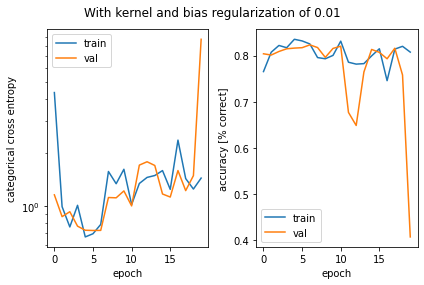

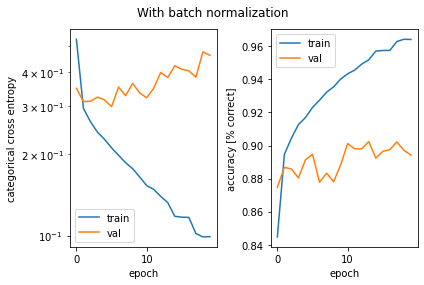

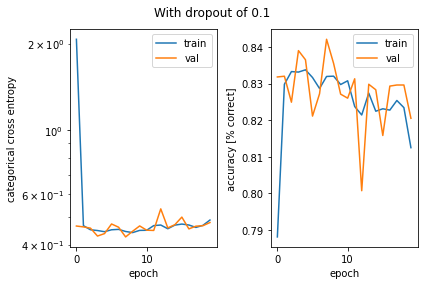

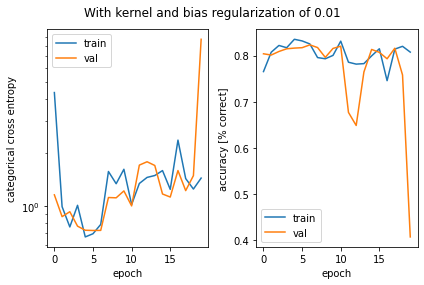

In [ ]:
plot_history(history_batch,"With batch normalization")
plot_history(history_drop,"With dropout of 0.1")
plot_history(history_reg,"With kernel and bias regularization of 0.01")

In [ ]:
model_optimal = build_convolutional_network(number_of_hidden_layers = 1, units = 100, optimizer='adam', batchNormalization=True, dropOut=0.1)
history_optimal = model_optimal.fit(x_fashion_train_conv, y_fashion_train_conv, batch_size=128, epochs=20, verbose=0, validation_data=(x_fashion_test_conv, y_fashion_test_conv))

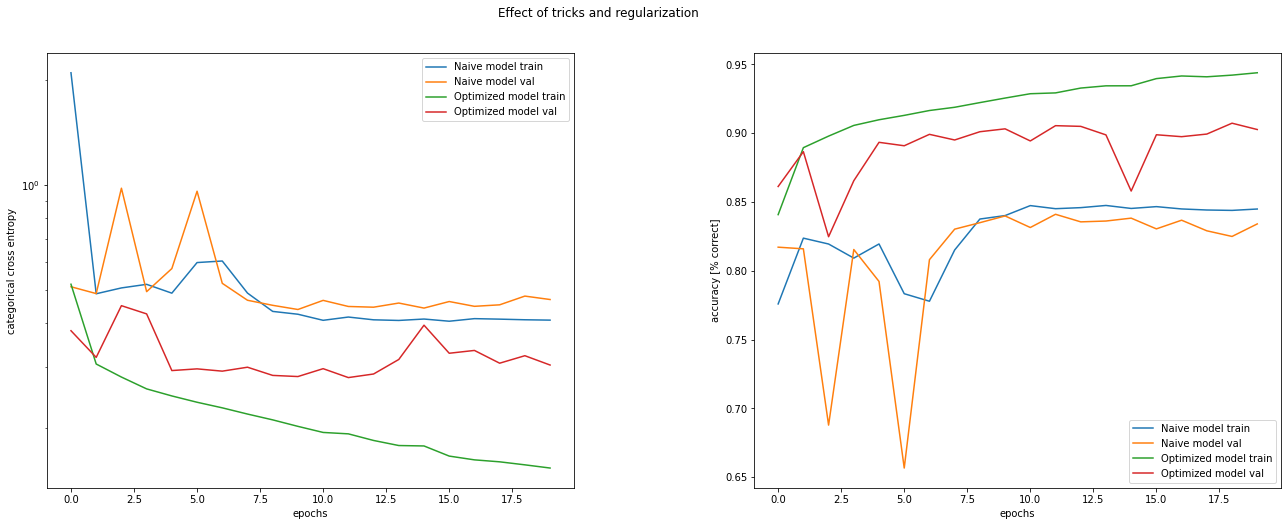

In [ ]:
# *** EXERCISE 6.3 ***
fig_comparison = comparison_plot(history_6_1, history_optimal, 'Naive model', 'Optimized model', 'Effect of tricks and regularization')
fig_comparison.set_size_inches(20,8)